In [1]:
# 모듈 로딩
import numpy as np
import pandas as pd
# import seaborn as sns
# import urllib.request
import random
import os
import cv2
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'Malgun Gothic'
# import warnings
# warnings.filterwarnings(action='ignore'

import tensorflow as tf
from keras.models import Sequential, Model, save_model #, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical, plot_model, set_random_seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
# 랜덤값 고정
np.random.seed(42)
tf.random.set_seed(42)
set_random_seed(42)

In [3]:
# train, test 데이터 불러오기
train=pd.read_csv('/tour_data//train.csv')
test=pd.read_csv('/tour_data/test.csv')

### [1] 데이터 살펴보기

In [4]:
train.head()

,id,img_path,overview,cat1,cat2,cat3
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식


In [5]:
# 결측치 확인
train.isnull().sum()

id          0
img_path    0
overview    0
cat1        0
cat2        0
cat3        0
dtype: int64

In [6]:
# 중복치 확인 및 제거
train.duplicated().sum()

0

In [7]:
# 대, 중, 소분류 확인
print(len(train.cat1.value_counts()), len(train.cat2.value_counts()), len(train.cat3.value_counts()))
print(train.cat1.value_counts(), '\n')
print(train.cat2.value_counts(), '\n')
print(train.cat3.value_counts())

6 18 128
인문(문화/예술/역사)    5614
음식              4912
레포츠             2611
자연              1719
숙박              1434
쇼핑               696
Name: cat1, dtype: int64 

음식점       4912
육상 레포츠    2288
자연관광지     1578
역사관광지     1571
숙박시설      1434
문화시설      1220
휴양관광지      889
체험관광지      805
쇼핑         696
축제         569
건축/조형물     328
수상 레포츠     277
관광자원       141
공연/행사      139
산업관광지       93
복합 레포츠      24
항공 레포츠      11
레포츠소개       11
Name: cat2, dtype: int64 

한식                3438
야영장,오토캠핑장         1558
바/까페               785
유적지/사적지            622
일반축제               549
                  ... 
MTB                  2
대중콘서트                2
인라인(실내 인라인 포함)       2
스카이다이빙               2
클래식음악회               2
Name: cat3, Length: 128, dtype: int64


## [1-2] 이미지 데이터(train) 불러오기

In [8]:
IMG_PATH='/tour_data//image/train/'
img_path_list=os.listdir(IMG_PATH)

In [26]:
img_list=[]
file_list=[]

for file in img_path_list:
    im = plt.imread(IMG_PATH + file)
    im = cv2.resize(im, (64, 64))
    im = im.reshape(-1, 64, 64, 3)
    img_list.append(im)
    file_list.append(file.split('.jpg')[0])

In [27]:
file_list[:5]

['TRAIN_00000', 'TRAIN_00001', 'TRAIN_00002', 'TRAIN_00003', 'TRAIN_00004']

In [28]:
train_img_data=np.concatenate(img_list)

In [29]:
train_img_data.shape

(16986, 64, 64, 3)

## [2] 전처리

In [30]:
# 라벨 인코더
le = LabelEncoder()
target1 = le.fit_transform(train.cat1)
target2 = le.fit_transform(train.cat2)
target3 = le.fit_transform(train.cat3)

In [31]:
target1.shape, target2.shape, target3.shape

((16986,), (16986,), (16986,))

In [32]:
# train, test 분리
X_train, X_test, y_train, y_test=train_test_split(train_img_data, target2,
                                                 stratify=target2,
                                                 random_state=42,
                                                 test_size=0.2)

# train, val 분리
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train,
                                                 stratify=y_train,
                                                 random_state=42,
                                                 test_size=0.2)

In [33]:
X_train.shape, X_test.shape, X_val.shape

((10870, 64, 64, 3), (3398, 64, 64, 3), (2718, 64, 64, 3))

## [3] 모델 구상

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 전결합층
model.add(Flatten())    # 벡터형태로 reshape
model.add(Dense(512))   # 출력
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(18, Activation('softmax')))

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_11 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_12 (Activation)  (None, 32, 32, 64)        0         
                                                      

In [36]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## [3-2] 모델 생성

In [37]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [38]:
# 모델 학습 데이터 전처리
# from sklearn.preprocessing import StandardScaler

# scaler=StandardScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.fit_transform(X_test)
# X_val=scaler.fit_transform(X_val)
X_train=X_train/255.0
X_test=X_test/255.0
X_val=X_val/255.0

## [3-3] 모델 학습

In [43]:
MODEL_PATH='tour_model_cat2_ver2.h5'
stopCB = EarlyStopping(monitor='val_accuracy', patience=5)
cpCB = ModelCheckpoint(filepath=MODEL_PATH, verbose=1, save_best_only=True)
Epochs=100
Batch_size=64

In [44]:
history=model.fit(X_train, y_train,
                 epochs=Epochs,
                 batch_size=Batch_size,
                 validation_data=(X_val, y_val),
                 callbacks=[stopCB, cpCB])

Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.8254
Epoch 1: val_loss improved from inf to 2.33441, saving model to tour_model_cat2_ver2.h5
170/170 [==============================] - 36s 209ms/step - loss: 0.5227 - accuracy: 0.8254 - val_loss: 2.3344 - val_accuracy: 0.4570
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8699
Epoch 2: val_loss did not improve from 2.33441
170/170 [==============================] - 43s 252ms/step - loss: 0.4029 - accuracy: 0.8699 - val_loss: 2.6182 - val_accuracy: 0.4448
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8925
Epoch 3: val_loss did not improve from 2.33441
170/170 [==============================] - 59s 347ms/step - loss: 0.3310 - accuracy: 0.8925 - val_loss: 2.9170 - val_accuracy: 0.4540
Epoch 4/100
170/170 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9095
Epoch 4: val_loss did not im

## [4] 모델평가

In [47]:
model.evaluate(X_train, y_train)

340/340 [==============================] - 8s 23ms/step - loss: 0.0136 - accuracy: 0.9986


[0.013607831671833992, 0.9986200332641602]

In [48]:
model.evaluate(X_test, y_test)

107/107 [==============================] - 3s 23ms/step - loss: 3.1344 - accuracy: 0.4305


[3.1344127655029297, 0.4305473864078522]

In [49]:
model.evaluate(X_val, y_val)

85/85 [==============================] - 2s 24ms/step - loss: 3.1876 - accuracy: 0.4558


[3.187607765197754, 0.45584988594055176]

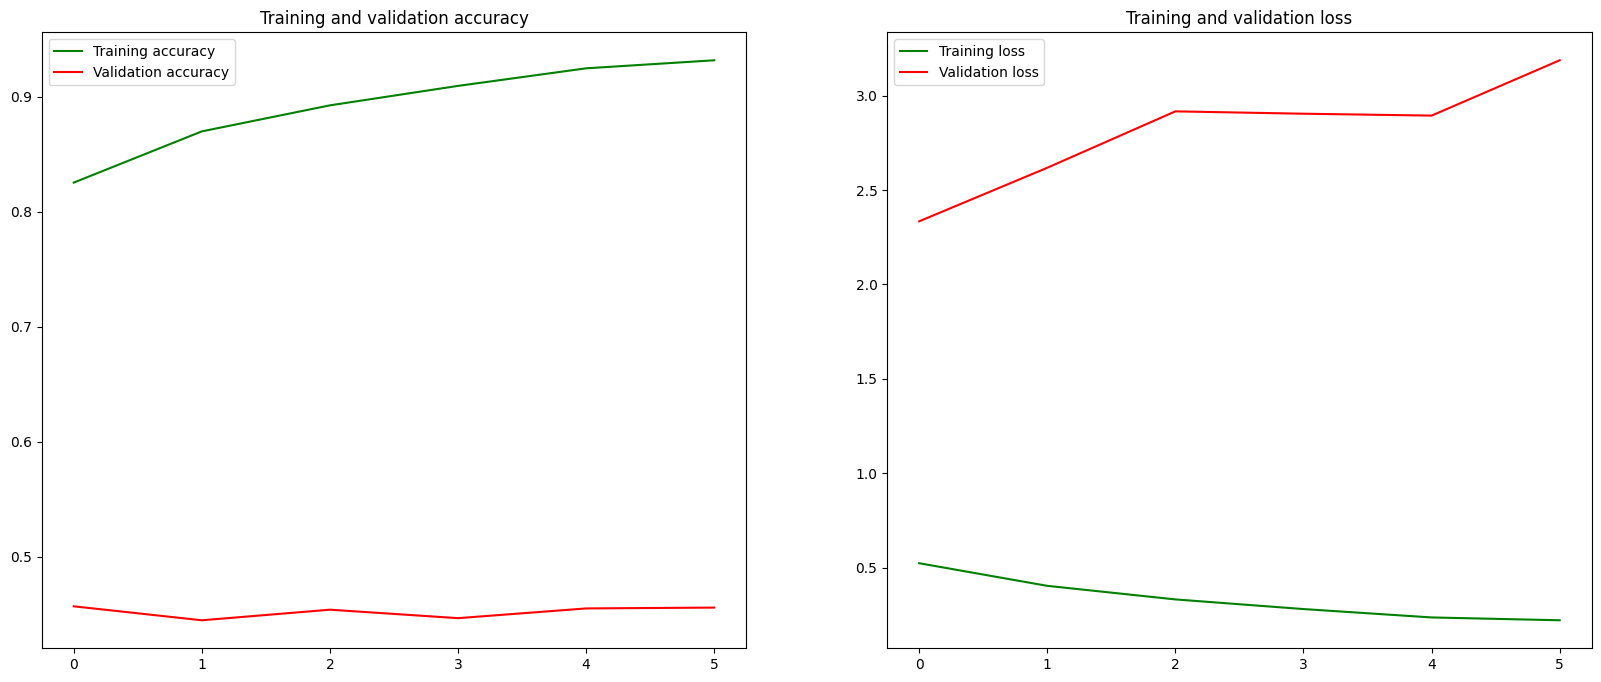

In [50]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(20, 8))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend(fontsize=10)
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)

## [5] 예측